In [1]:
%matplotlib inline

import h5py
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import scipy
from collections import Counter
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
from IPython.display import display
from numpy.random import shuffle
from scipy.spatial.distance import pdist, squareform
from scipy.spatial import KDTree

mpl.style.use('seaborn')

C:\Users\jouse\Anaconda2\envs\py36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def get_accuracy(y_true, y_pred): 
    """
    Calculate the accuracy score.
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.sum(y_true == y_pred)/len(y_true)

def flat(data):
    """
    Flatten images in the data array. 
    """
    return data.reshape(data.shape[0], data.shape[1]**2)

In [3]:
# load training data and labels
with h5py.File('images_training.h5','r') as H:
    data = np.copy(H['data'])
    data = np.array([x/np.amax(x) for x in data]) # normalize images
with h5py.File('labels_training.h5','r') as H:
    label = np.copy(H['label'])

In [4]:
# load testing data and labels
with h5py.File('images_testing.h5','r') as H:
    data_test = np.copy(H['data'])
    data_test = np.array([x/np.amax(x) for x in data_test]) # normalize images
with h5py.File('labels_testing_2000.h5','r') as H:
    label_test = np.copy(H['label'])

In [5]:
def plot_group_mean(n, data):
    """
    Plot the aggregate average of each class. 
    """
    data = data
    fig, ax = plt.subplots()
    plt.imshow(np.mean(data[label == n], axis=0))
    plt.show()
    
choice = np.array(list(set(label)))
interact(plot_group_mean, n=choice, data=fixed(data))

interactive(children=(Dropdown(description='n', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9), value=0), Output()), _…

<function __main__.plot_group_mean(n, data)>

## Singular Value Decomposition 

In [6]:
k_svd = 10 # number of singular values to save

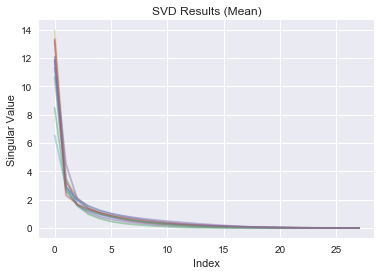

In [7]:
# Singular Value Decomposition on training images

u, s, vh = np.linalg.svd(data)
data_svd = np.array([u[i][:,:k_svd] @ np.diag(s[i][:k_svd]) @ vh[i][:k_svd:,] for i in range(s.shape[0])])

fig, ax = plt.subplots()
for n in list(set(label)):
    x = np.arange(data[0].shape[0])
    y = np.mean(s[label == n], axis=0)
    yerr = np.std(s[label == n], axis=0)
    ax.errorbar(x, y, yerr=0, alpha=0.5)
ax.set_xlabel('Index')
ax.set_ylabel('Singular Value')
ax.set_title('SVD Results (Mean)')
plt.show()

In [8]:
def svd_2d_scatter(n_0, n_1, sv):
    """
    Plot the 2d scatter plot for a selected pair of singular value components. 
    """
    fig, ax = plt.subplots()
    ax.scatter(sv[:,n_0], sv[:,n_1], c=label, s=0.5, cmap='rainbow', alpha=0.5)
    ax.set_xlabel('Singular Value {}'.format(n_0))
    ax.set_ylabel('Singular Value {}'.format(n_1))
    ax.set_title('SVD Results')
    plt.show()

choice = np.arange(data[0].shape[0])
interact(svd_2d_scatter, n_0=choice, n_1=choice, sv=fixed(s))

interactive(children=(Dropdown(description='n_0', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1…

<function __main__.svd_2d_scatter(n_0, n_1, sv)>

In [9]:
# Singular Value Decomposition on testing images

u, s, vh = np.linalg.svd(data_test)
data_test_svd = np.array([u[i][:,:k_svd] @ np.diag(s[i][:k_svd]) @ vh[i][:k_svd:,] for i in range(s.shape[0])])

In [10]:
choice = np.array(list(set(label)))
interact(plot_group_mean, n=choice, data=fixed(data_svd))

interactive(children=(Dropdown(description='n', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9), value=0), Output()), _…

<function __main__.plot_group_mean(n, data)>

## Principal Component Analysis

Note: PCA is applied to the entire dataset, while SVD is applied to each image. 

In [11]:
def PCA(n_components, data):
    """
    Principal Component Analysis
    
    Parameters: 
    
    n_components: int
        Number of principal components to use
        
    data : array-like, shape = (n_samples, n_features)
        Data to perform PCA on
    
    """
    n_components = n_components
    data = data
    X = data - np.mean(data, axis=0) # data matrix normalized by mean
    S = np.cov(X.T) # compute covariance matrix of X
    L, V = np.linalg.eig(S) # L - array of eigenvalues; V - matrix of eigenvectors
    V = V[:,np.argsort(-L)][:,:n_components] # sort eigenvectors by descending order on eigenvalues
    L = -np.sort(-L)[:n_components] # sort eigenvalues by descending order
    X_PCA = V.T @ X.T
    X_PCA = X_PCA.T
    return X_PCA, V

In [29]:
n_components = 20
X_PCA, V = PCA(n_components=n_components, data=np.append(flat(data), flat(data_test), axis=0))
data_pca = X_PCA[:data.shape[0]]
data_test_pca = X_PCA[-data_test.shape[0]:]
print(data_pca.shape)
print(data_test_pca.shape)

(30000, 20)
(5000, 20)


In [18]:
def pca_2d_scatter(n_0, n_1, data, label):
    fig, ax = plt.subplots()
    ax.scatter(data[:,n_0], data[:,n_1], c=label, s=0.5, cmap='rainbow', alpha=0.5)
    ax.set_xlabel('Principal Component {}'.format(n_0))
    ax.set_ylabel('Principal Component {}'.format(n_1))
    ax.set_title('PCA Results')
    plt.show()

choice = np.arange(n_components)
interact(pca_2d_scatter, n_0=choice, n_1=choice, data=fixed(data_pca), label=fixed(label))

interactive(children=(Dropdown(description='n_0', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1…

<function __main__.pca_2d_scatter(n_0, n_1, data, label)>

## Some functions

In [14]:
# def kfold(N, k=10):
#     """
#     Generate lists of indices for data divided into k equal parts for cross validation. 
    
#     Parameters
#     ----------
#     N: int
#         number of samples in the data. 
    
#     k: int
#         number of parts the data will be split into. 
    
#     Returns
#     -------
#     indices: array, shape(k,) 
#         An array of arrays, each containing the indices for one part of data. 
#     """
    
#     arr = np.arange(N)
#     np.random.shuffle(arr)
#     indices = np.array([arr[i::k] for i in range(k)])
    
#     return indices

In [15]:
# def stratified_kfold(N, label, k=10):
#     """
#     Generate lists of indices for data divided into k equal parts for cross validation. 
    
#     Parameters
#     ----------
#     N: int
#         Number of samples in the data. 
        
#     label: array, shape(n_samples,)
#         True labels for the data. 
    
#     k: int
#         Number of parts the data will be split into. 
    
#     Returns
#     -------
#     indices: array, shape(k,) 
#         An array of arrays, each containing the indices for one part of data. 
#     """
    
#     list_label = np.array(list(set(label)))
#     label_group = np.array([np.where(label == i)[0] for i in list_label])
#     for i in range(label.shape[0]):
#         shuffle(label_group[i])
#     indices = []
#     for i in range(k):
#         i_fold = np.array([label_group[j][i::k] for j in range(label.shape[0])])
#         indices.append(np.hstack(i_fold))
#     indices = np.array(indices)
#     return indices

In [ ]:
# def get_f1(y_true, y_pred): 
#     """
#     Calculate the F1 score. If there are more than two classes, return the unweighted average of all classes. 
#     """
#     y_true = np.array(y_true)
#     y_pred = np.array(y_pred)
#     class_list = np.array(list(set(y_true)))
#     precision = np.array([(np.sum((y_true == y_pred) & (y_true == n))/np.sum(y_pred == n)) if np.sum(y_pred == n) > 0 
#                                else 0 for n in class_list])
#     recall = np.array([(np.sum((y_true == y_pred) & (y_true == n))/np.sum(y_true == n)) for n in class_list])
#     f1 = np.array([2*(precision[n] * recall[n]) / (precision[n] + recall[n]) if precision[n] + recall[n] > 0 
#                    else 0 for n in class_list])
#     return np.mean(f1)
    
# def get_recall(y_true, y_pred):
#     """
#     Calculate the recall score. If there are more than two classes, return the unweighted average of all classes. 
#     """
#     y_true = np.array(y_true)
#     y_pred = np.array(y_pred)
#     class_list = np.array(list(set(y_true)))
#     score_list = np.array([(np.sum((y_true == y_pred) & (y_true == n))/np.sum(y_true == n)) for n in class_list])
#     return np.mean(score_list)

# def get_precision(y_true, y_pred): 
#     """
#     Calculate the precision score. If there are more than two classes, return the unweighted average of all classes. 
#     """
#     y_true = np.array(y_true)
#     y_pred = np.array(y_pred)
#     class_list = np.array(list(set(y_true)))
#     score_list = np.array([(np.sum((y_true == y_pred) & (y_true == n))/np.sum(y_pred == n)) if np.sum(y_pred == n) > 0 
#                            else 0 for n in class_list])
#     return np.mean(score_list)